In [1]:
import json
import matplotlib
from IPython.core.pylabtools import figsize
import warnings

warnings.simplefilter('ignore')
root = r'C:\\Users\\admin\\Desktop\\Python_Prog\\PyMC3\\Styles\\bmh_matplotlibrc.json'
s = json.load(open(root))
matplotlib.rcParams.update(s)

In [2]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import tarfile
from IPython.display import display, Image
from scipy import ndimage
from sklearn.linear_model import LogisticRegression
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Donwload the dataset
The data consist of characters rendered in a variety of font on a 28x28 image. The label are limited to 'A' through 'J'(10 classes)
The training ste has about 500K and the testset 19000 labelled examples.(we shouldbe able to train it quickly on any machine)

In [3]:
url = 'http://commondatastorage.googleapis.com/books1000/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

train_filename = maybe_download('notMNIST_large.tar.gz', 247336696)
test_filename = maybe_download('notMNIST_small.tar.gz', 8458043)

Attempting to download: notMNIST_large.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_large.tar.gz
Attempting to download: notMNIST_small.tar.gz
0%....5%....10%....15%....20%....25%....30%....35%....40%....45%....50%....55%....60%....65%....70%....75%....80%....85%....90%....95%....100%
Download Complete!
Found and verified .\notMNIST_small.tar.gz


In [4]:
# Extract the datset from compressed .tar.gz file. Thismust give a set of directories, labelled A through J


num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
  data_folders = [
    os.path.join(root, d) for d in sorted(os.listdir(root))
    if os.path.isdir(os.path.join(root, d))]
  if len(data_folders) != num_classes:
    raise Exception(
      'Expected %d folders, one per class. Found %d instead.' % (
        num_classes, len(data_folders)))
  print(data_folders)
  return data_folders
  
train_folders = maybe_extract(train_filename)
test_folders = maybe_extract(test_filename)

Extracting data for .\notMNIST_large. This may take a while. Please wait.
['.\\notMNIST_large\\A', '.\\notMNIST_large\\B', '.\\notMNIST_large\\C', '.\\notMNIST_large\\D', '.\\notMNIST_large\\E', '.\\notMNIST_large\\F', '.\\notMNIST_large\\G', '.\\notMNIST_large\\H', '.\\notMNIST_large\\I', '.\\notMNIST_large\\J']
Extracting data for .\notMNIST_small. This may take a while. Please wait.
['.\\notMNIST_small\\A', '.\\notMNIST_small\\B', '.\\notMNIST_small\\C', '.\\notMNIST_small\\D', '.\\notMNIST_small\\E', '.\\notMNIST_small\\F', '.\\notMNIST_small\\G', '.\\notMNIST_small\\H', '.\\notMNIST_small\\I', '.\\notMNIST_small\\J']


In [61]:
import random
def Display_image(folders):
    for folder in folders:
        image_file = os.listdir(folder)
        path = folder + '\\' + random.choice(image_file)
        img = Image(filename = path)
        display(img)
print("Train folders")       
Display_image(train_folders)
print("Test folders")
Display_image(test_folders)

Train folders


Test folders


In [5]:
#We would now load each class into separate dataset;, store them on disk and curate them independently.
#Then merge them into a single dataset of manageable size, we <ould convert the datasetin a 3D array(image index, x, y) of 
#floatiing point values, normalized to have approximately ezro mean and standard deviation ~ 0.5.

image_size = 28  # Pixel width and height.
pixel_depth = 255.0  # Number of levels per pixel.

def load_letter(folder, min_num_images):
  """Load the data for a single letter label."""
  image_files = os.listdir(folder)
  dataset = np.ndarray(shape=(len(image_files), image_size, image_size),
                         dtype=np.float32)
  print(folder)
  num_images = 0
  for image in image_files:
    image_file = os.path.join(folder, image)
    try:
      image_data = (ndimage.imread(image_file).astype(float) - 
                    pixel_depth / 2) / pixel_depth
      if image_data.shape != (image_size, image_size):
        raise Exception('Unexpected image shape: %s' % str(image_data.shape))
      dataset[num_images, :, :] = image_data
      num_images = num_images + 1
    except IOError as e:
      print('Could not read:', image_file, ':', e, '- it\'s ok, skipping.')
    
  dataset = dataset[0:num_images, :, :]
  if num_images < min_num_images:
    raise Exception('Many fewer images than expected: %d < %d' %
                    (num_images, min_num_images))
    
  print('Full dataset tensor:', dataset.shape)
  print('Mean:', np.mean(dataset))
  print('Standard deviation:', np.std(dataset))
  return dataset
        
def maybe_pickle(data_folders, min_num_images_per_class, force=False):
  dataset_names = []
  for folder in data_folders:
    set_filename = folder + '.pickle'
    dataset_names.append(set_filename)
    if os.path.exists(set_filename) and not force:
      # You may override by setting force=True.
      print('%s already present - Skipping pickling.' % set_filename)
    else:
      print('Pickling %s.' % set_filename)
      dataset = load_letter(folder, min_num_images_per_class)
      try:
        with open(set_filename, 'wb') as f:
          pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
      except Exception as e:
        print('Unable to save data to', set_filename, ':', e)
  
  return dataset_names

train_datasets = maybe_pickle(train_folders, 45000)
test_datasets = maybe_pickle(test_folders, 1800)

Pickling .\notMNIST_large\A.pickle.
.\notMNIST_large\A
Could not read: .\notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png : cannot identify image file '.\\notMNIST_large\\A\\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png : cannot identify image file '.\\notMNIST_large\\A\\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png' - it's ok, skipping.
Could not read: .\notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png : cannot identify image file '.\\notMNIST_large\\A\\Um9tYW5hIEJvbGQucGZi.png' - it's ok, skipping.
Full dataset tensor: (52909, 28, 28)
Mean: -0.12825
Standard deviation: 0.443121
Pickling .\notMNIST_large\B.pickle.
.\notMNIST_large\B
Could not read: .\notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png : cannot identify image file '.\\notMNIST_large\\B\\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png' - it's ok, skipping.
Full dataset tensor: (52911, 28, 28)
Mean: -0.00756303
Standard deviation: 0.

Train datasets : 


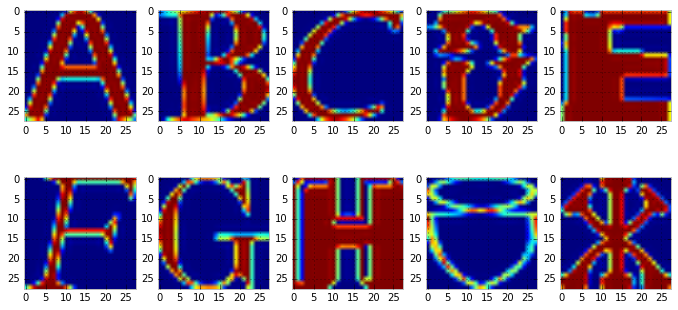

In [146]:
def _Display_image(datasets):
    image_folders = []
    for elem in datasets:
        with open(elem, 'rb') as f:
            data = pickle.load(f)
        image_folders.append(data)
        
    fig, axs = plt.subplots(2,5, figsize=(12, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
        
    for i, elem in enumerate(image_folders):
        image = random.choice(elem)
        axs[i].imshow(image)
        
print("Train datasets : ")
_Display_image(train_datasets)

Test datasets : 


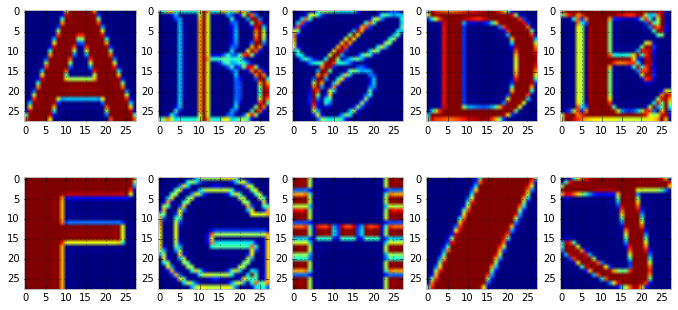

In [147]:
print("Test datasets : ")
_Display_image(test_datasets)

#### We expect the data to balance across classes 

In [155]:
def Check_balance(datasets):
    for data_folder in datasets:
        with open(data_folder,'rb') as f:
            data = pickle.load(f)
            print(len(data))
            
Check_balance(train_datasets)

52909
52911
52912
52911
52912
52912
52912
52912
52912
52911


In [156]:
Check_balance(test_datasets)

1872
1873
1873
1873
1873
1872
1872
1872
1872
1872


In [157]:
def make_arrays(nb_rows, img_size):
  if nb_rows:
    dataset = np.ndarray((nb_rows, img_size, img_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
  else:
    dataset, labels = None, None
  return dataset, labels

def merge_datasets(pickle_files, train_size, valid_size=0):
  num_classes = len(pickle_files)
  valid_dataset, valid_labels = make_arrays(valid_size, image_size)
  train_dataset, train_labels = make_arrays(train_size, image_size)
  vsize_per_class = valid_size // num_classes
  tsize_per_class = train_size // num_classes
    
  start_v, start_t = 0, 0
  end_v, end_t = vsize_per_class, tsize_per_class
  end_l = vsize_per_class+tsize_per_class
  for label, pickle_file in enumerate(pickle_files):       
    try:
      with open(pickle_file, 'rb') as f:
        letter_set = pickle.load(f)
        # let's shuffle the letters to have random validation and training set
        np.random.shuffle(letter_set)
        if valid_dataset is not None:
          valid_letter = letter_set[:vsize_per_class, :, :]
          valid_dataset[start_v:end_v, :, :] = valid_letter
          valid_labels[start_v:end_v] = label
          start_v += vsize_per_class
          end_v += vsize_per_class
                    
        train_letter = letter_set[vsize_per_class:end_l, :, :]
        train_dataset[start_t:end_t, :, :] = train_letter
        train_labels[start_t:end_t] = label
        start_t += tsize_per_class
        end_t += tsize_per_class
    except Exception as e:
      print('Unable to process data from', pickle_file, ':', e)
      raise
    
  return valid_dataset, valid_labels, train_dataset, train_labels
            
            
train_size = 200000
valid_size = 10000
test_size = 10000

valid_dataset, valid_labels, train_dataset, train_labels = merge_datasets(
  train_datasets, train_size, valid_size)
_, _, test_dataset, test_labels = merge_datasets(test_datasets, test_size)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (200000, 28, 28) (200000,)
Validation: (10000, 28, 28) (10000,)
Testing: (10000, 28, 28) (10000,)


In [160]:
#Randomize the data since it's imortant to have the labels weel shuffled for the training and tests 
#distribution to match

def randomize(dataset, labels):
  permutation = np.random.permutation(labels.shape[0])
  shuffled_dataset = dataset[permutation,:,:]
  shuffled_labels = labels[permutation]
  return shuffled_dataset, shuffled_labels

train_dataset, train_labels = randomize(train_dataset, train_labels)
test_dataset, test_labels = randomize(test_dataset, test_labels)
valid_dataset, valid_labels = randomize(valid_dataset, valid_labels)

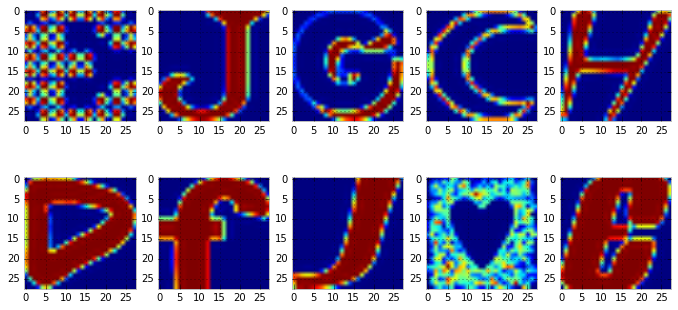

In [162]:
def Check_again(dataset):
    fig, axs = plt.subplots(2,5, figsize=(12, 5), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)

    axs = axs.ravel()
    for i in np.arange(10):
        axs[i].imshow(dataset[i])
        
Check_again(train_dataset)

In [163]:
#Save data
pickle_file = os.path.join(data_root, 'notMNIST.pickle')

try:
  f = open(pickle_file, 'wb')
  save = {
    'train_dataset': train_dataset,
    'train_labels': train_labels,
    'valid_dataset': valid_dataset,
    'valid_labels': valid_labels,
    'test_dataset': test_dataset,
    'test_labels': test_labels,
    }
  pickle.dump(save, f, pickle.HIGHEST_PROTOCOL)
  f.close()
except Exception as e:
  print('Unable to save data to', pickle_file, ':', e)
  raise

This dataset might contain a lot of overlapping samples, including dat that's also contained in the validation and the test set ! 
Overlap between training and test can skew the results if we expect to use our model in an environment wher there is never an 
overlap, but are actually ok if we expect to see training samples recur when we see it.
Let's measure how much orvelap there is in our subsets.

In [206]:
from sklearn import metrics

def fitModel(sample_size, train_dataset, train_labels):
    X = train_dataset[:sample_size, :, :]
    X = X.reshape(sample_size, 28*28)
    y = train_labels[:sample_size]
    
    Lr = LogisticRegression()
    model = Lr.fit(X, y)
    return model

def testModel(model, samle_size,  test_dataset, test_labels):
    X_test = test_dataset[:sample_size, :, :]
    X_test = X_test.reshape(sample_size, 28*28)
    y_test = test_labels[:sample_size]
    predictions = model.predict(X_test)
    accuracy = len(predictions[predictions == y_test])/len(predictions)
    print("Accuracy {}".format(accuracy))
    print(metrics.classification_report(y_test, predictions))

In [207]:
sample_size = 50
model_50 = fitModel(sample_size, train_dataset, train_labels)
testModel(model_50, 50, test_dataset, test_labels)

Accuracy 0.46
             precision    recall  f1-score   support

          0       0.80      0.80      0.80         5
          1       0.33      0.50      0.40         6
          2       1.00      0.11      0.20         9
          3       0.00      0.00      0.00         5
          4       0.20      1.00      0.33         2
          5       0.33      0.50      0.40         2
          6       0.36      0.80      0.50         5
          7       0.60      0.38      0.46         8
          8       0.80      0.80      0.80         5
          9       1.00      0.33      0.50         3

avg / total       0.59      0.46      0.43        50



In [208]:
sample_size = 100
model_100 = fitModel(sample_size, train_dataset, train_labels)
testModel(model_50, 100, test_dataset, test_labels)

Accuracy 0.64
             precision    recall  f1-score   support

          0       0.79      0.73      0.76        15
          1       0.50      0.44      0.47         9
          2       0.82      0.64      0.72        14
          3       0.88      0.88      0.88         8
          4       0.29      0.50      0.36         8
          5       0.64      0.78      0.70         9
          6       0.58      0.70      0.64        10
          7       0.71      0.38      0.50        13
          8       0.64      0.78      0.70         9
          9       0.75      0.60      0.67         5

avg / total       0.67      0.64      0.64       100



In [209]:
sample_size = 1000
model_1000 = fitModel(sample_size, train_dataset, train_labels)
testModel(model_50, 1000, test_dataset, test_labels)

Accuracy 0.839
             precision    recall  f1-score   support

          0       0.89      0.82      0.86       112
          1       0.86      0.81      0.83       117
          2       0.93      0.85      0.89        92
          3       0.87      0.89      0.88        92
          4       0.83      0.84      0.83        98
          5       0.82      0.92      0.87        91
          6       0.81      0.83      0.82       107
          7       0.84      0.80      0.82       103
          8       0.78      0.84      0.81        95
          9       0.78      0.81      0.79        93

avg / total       0.84      0.84      0.84      1000



In [210]:
sample_size = 5000
model_5000 = fitModel(sample_size, train_dataset, train_labels)
testModel(model_50, 5000, test_dataset, test_labels)

Accuracy 0.8526
             precision    recall  f1-score   support

          0       0.86      0.85      0.86       505
          1       0.86      0.84      0.85       516
          2       0.87      0.89      0.88       490
          3       0.90      0.90      0.90       502
          4       0.85      0.81      0.83       477
          5       0.85      0.89      0.87       473
          6       0.88      0.83      0.86       521
          7       0.88      0.83      0.85       512
          8       0.76      0.84      0.80       488
          9       0.83      0.85      0.84       516

avg / total       0.85      0.85      0.85      5000

